## Data Loading and Visualization

### Overview

- Source: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection?resource=download

- This Kaggle dataset uses news headlines from two websites: TheOnion (sarcastic) and HuffPost (non-sarcastic).

- Each record in the dataset has three attributes:

    **is_sarcastic**: 1 if the record is sarcastic, otherwise 0.

    **headline**: The headline of the news article.

    **article_link**: Link to the original news article, useful for collecting supplementary data.

In [32]:
# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import zipfile
import os
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, f1_score

In [5]:
def unzip(zip_path='/content/archive.zip', extract_to='/content/data/'):

    """Unzip the file into a 'data' folder."""

    # Check if the file exists
    if not os.path.exists(zip_path):
        print(f"File does not exist: {zip_path}")
        return

    # Check if the file is a zip file by trying to open it
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
    except zipfile.BadZipFile:
        print("The file is not a valid zip file or is corrupted.")
        return

    print("Files extracted to:", extract_to)

    # Optionally, list the files in the directory to confirm
    for dirname, _, filenames in os.walk(extract_to):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# call function
unzip()

Files extracted to: /content/data/
/content/data/Sarcasm_Headlines_Dataset.json
/content/data/Sarcasm_Headlines_Dataset_v2.json


In [6]:
class DataLoading():
    def __init__(self, json_path):
        # read file
        self.df = pd.read_json(json_path, lines=True)
        plt.rcdefaults()

    # perform exploratory data analysis
    def EDA(self):
        # Basic info
        print("Dataset size:", self.df.shape)
        print("First few rows:")
        print(self.df.head())
        print("Null value check:")
        print(self.df.isnull().sum())

        # Class balance
        print("\nClass distribution:")
        print(self.df['is_sarcastic'].value_counts(normalize=True))

        # Text length analysis
        self.df['headline_length'] = self.df['headline'].apply(lambda x: len(x.split()))
        self.df['headline_char_count'] = self.df['headline'].apply(len)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(self.df['headline_length'], bins=30, kde=True)
        plt.title('Headline Length Distribution')
        plt.subplot(1, 2, 2)
        sns.histplot(self.df['headline_char_count'], bins=30, kde=True)
        plt.title('Headline Character Count Distribution')
        plt.show()

        # Word frequency analysis (example with unigrams)
        cv = CountVectorizer(stop_words='english')
        words = cv.fit_transform(self.df['headline'])
        sum_words = words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        top_words = words_freq[:10]
        print("Top words and their counts:")
        print(top_words)

        # Barplot for most commonly occuring words:
        words, counts = zip(*top_words)

        # Creating the bar plot
        plt.figure(figsize=(10, 8))  # Adjust the figure size as per your needs
        plt.bar(words, counts, color='skyblue')  # Change the color as you like
        plt.title('Top 10 Most Common Words')  # Title of the plot
        plt.xlabel('Words')  # X-axis label
        plt.ylabel('Counts')  # Y-axis label
        plt.xticks(rotation=45)  # Rotate the words on x-axis for better readability
        plt.show()  # Display the plot


        # Word cloud for sarcastic headlines
        sarcastic_df = self.df[self.df['is_sarcastic'] == 1]
        all_sarcastic_words = ' '.join(text for text in sarcastic_df['headline'])
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_sarcastic_words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

In [7]:
# load dataset into a dataframe
data_path = '/content/data/Sarcasm_Headlines_Dataset_v2.json'
data_loader = DataLoading(data_path)
df = data_loader.df

Dataset size: (28619, 3)
First few rows:
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  
Null value check:
is_sarcastic    0
headline        0
article_link    0
dtype: int64

Class distribution:
0    0.523603
1    0.476397
Name: is_sarcastic, dtype: float64


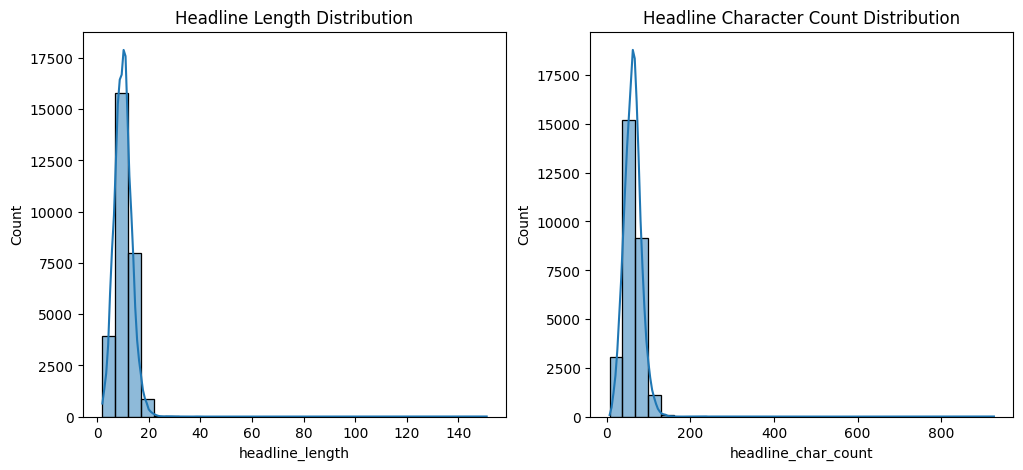

Top words and their counts:
[('trump', 1832), ('new', 1684), ('man', 1525), ('just', 676), ('report', 605), ('year', 587), ('woman', 549), ('day', 523), ('area', 501), ('time', 496)]


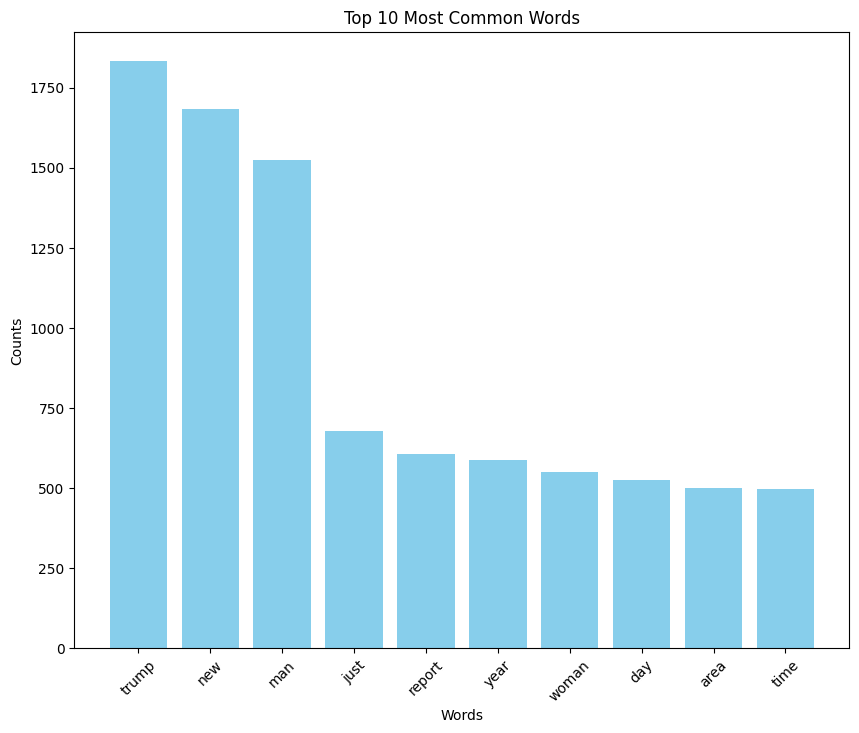

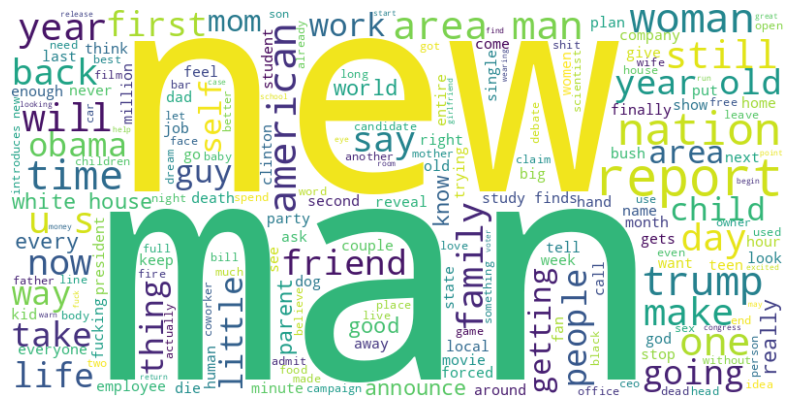

In [5]:
# perform exploratory data analysis
data_loader.EDA()

## Data Preprocessing

In [8]:
def Tokenize(df, vocab_size=10000, max_length=100):

        """ Tokenizes text data from a DataFrame column and pads the sequences for uniform length.

            Parameters:
            - df: DataFrame containing the text data in the 'headline' column.
            - vocab_size: Maximum number of words to keep, based on word frequency (default is 10,000).
            - max_length: Maximum length of all sequences (default is 100)

            Returns:
            - Padded, tokenized data as a NumPy array. """

        # Parameters
        trunc_type = 'post'
        padding_type = 'post'
        oov_tok = "<OOV>" # Out Of Vocabulary text assignment

        # Tokenization
        tokenizer = Tokenizer(num_words= vocab_size, oov_token=oov_tok)
        tokenizer.fit_on_texts(df['headline'])
        sequences = tokenizer.texts_to_sequences(df['headline'])

        # Get padded, tokenized data
        padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

        return padded

In [9]:
tokenized_data = Tokenize(df, vocab_size=10000, max_length=100)

In [8]:
tokenized_data[200,:]

array([ 475,  729,   54,   30,    1,   10,    4, 6450,    8, 2171,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [10]:
# Splitting the dataset - 70-15-15 split for training, validation and test sets respectively
X_train, X_temp, y_train, y_temp = train_test_split(tokenized_data, df['is_sarcastic'].values, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Model Architecture and Training

### Overview

- LSTM model for classifying tokens as sarcastic or not sarcastic
- it takes in tokenized data above
- Model Architecture:

  Embedding Layer: Maps vocab indices into dense vectors of fixed size (embedding_dim), set to work with the class's vocab size and input length.

  Bidirectional LSTM Layer: A 64-unit LSTM wrapped in a Bidirectional layer to capture dependencies in both directions of the input sequences.

  Dense Layer: A fully connected layer with 24 neurons and ReLU activation function.
  
  Output Dense Layer: A single neuron with a sigmoid activation function for binary classification (e.g., sarcastic or not).

In [20]:
# Defining F1 score as an evaluation metric
class F1ScoreCallback(Callback):
    def __init__(self, model, X_val, y_val):
        super().__init__()
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = []  # Initialize an empty list to store F1 scores

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        # Convert predictions and true values to binary
        y_pred_binary = np.round(y_pred).astype(int)
        y_true_binary = self.y_val.astype(int)
        # Calculate F1 score
        f1 = f1_score(y_true_binary, y_pred_binary, average='macro')
        self.f1_scores.append(f1)  # Store the F1 score
        print(f' - val_f1: {f1:.4f}')

In [21]:
class SarcasmLSTM():
    def __init__(self, tokenized_data, vocab_size=10000, max_length=100):
        self.padded = tokenized_data
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.model = None # initialize model attribute

    def build_model(self, embedding_dim = 16):

      # Model definition
        self.model = Sequential([
                                  # Create a word embedding layer
                                  Embedding(self.vocab_size, embedding_dim, input_length = self.max_length),

                                  # Create an LSTM layer with output size 64
                                  Bidirectional(LSTM(64)),

                                  # Fully connected output from the LSTM
                                  Dense(24, activation='relu'),

                                  # Use sigmoid activation for binary classification
                                  Dense(1, activation='sigmoid')
                                ])

        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, X_train, y_train, X_val, y_val, num_epochs=10):
          if self.model is None:
              print("Model has not been built. Call 'build_model' before training.")
              return

          # Define and initialize the F1 score callback
          f1_callback = F1ScoreCallback(self.model, X_val, y_val)

          print('\nTraining for', num_epochs, 'epochs.\n')
          # Training the model with the F1ScoreCallback
          history = self.model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[f1_callback])

          # Plotting training and validation loss
          plt.figure(figsize=(18, 6))

          plt.subplot(1, 3, 1)
          plt.plot(history.history['loss'], label='Training Loss')
          plt.plot(history.history['val_loss'], label='Validation Loss')
          plt.title('Training and Validation Loss')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()

          # Plotting training and validation accuracy
          plt.subplot(1, 3, 2)
          plt.plot(history.history['accuracy'], label='Training Accuracy')
          plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
          plt.title('Training and Validation Accuracy')
          plt.xlabel('Epoch')
          plt.ylabel('Accuracy')
          plt.legend()

          # Plotting F1 Score
          plt.subplot(1, 3, 3)
          plt.plot(f1_callback.f1_scores, label='Validation F1 Score')
          plt.title('Validation F1 Score')
          plt.xlabel('Epoch')
          plt.ylabel('F1 Score')
          plt.legend()

          plt.tight_layout()
          plt.show()

In [24]:
import gc

# If an instance of the model already exists, delete it
# to avoid building on previous model states
if 'model_instance' in locals():
    del model_instance

# Force garbage collection
gc.collect()

# Initialize the SarcasmLSTM class
model_instance = SarcasmLSTM(tokenized_data, vocab_size=10000, max_length=100)

# Build the model
model_instance.build_model(embedding_dim=16)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               41472     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 24)                3096      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 204593 (799.19 KB)
Trainable params: 204593 (799.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Training for 10 epochs.

Epoch 1/10
  6/627 [..............................] - ETA: 4:25 - loss: 0.6931 - accuracy: 0.5156

627/627 [==============================] - 31s 44ms/step - loss: 0.4045 - accuracy: 0.7987 - val_loss: 0.3538 - val_accuracy: 0.8346
Epoch 2/10
627/627 [==============================] - 18s 29ms/step - loss: 0.2100 - accuracy: 0.9151 - val_loss: 0.3507 - val_accuracy: 0.8542
Epoch 3/10
627/627 [==============================] - 15s 24ms/step - loss: 0.1385 - accuracy: 0.9491 - val_loss: 0.3870 - val_accuracy: 0.8493
Epoch 4/10
627/627 [==============================] - 16s 26ms/step - loss: 0.0793 - accuracy: 0.9714 - val_loss: 0.5100 - val_accuracy: 0.8402
Epoch 5/10
627/627 [==============================] - 14s 23ms/step - loss: 0.0441 - accuracy: 0.9853 - val_loss: 0.6796 - val_accuracy: 0.8348
Epoch 6/10
627/627 [==============================] - 14s 22ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.6940 - val_accuracy: 0.8372
Epoch 7/10
627/627 [==============================] - 16s 25ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.8491 - val_accuracy: 0.8346
Epo

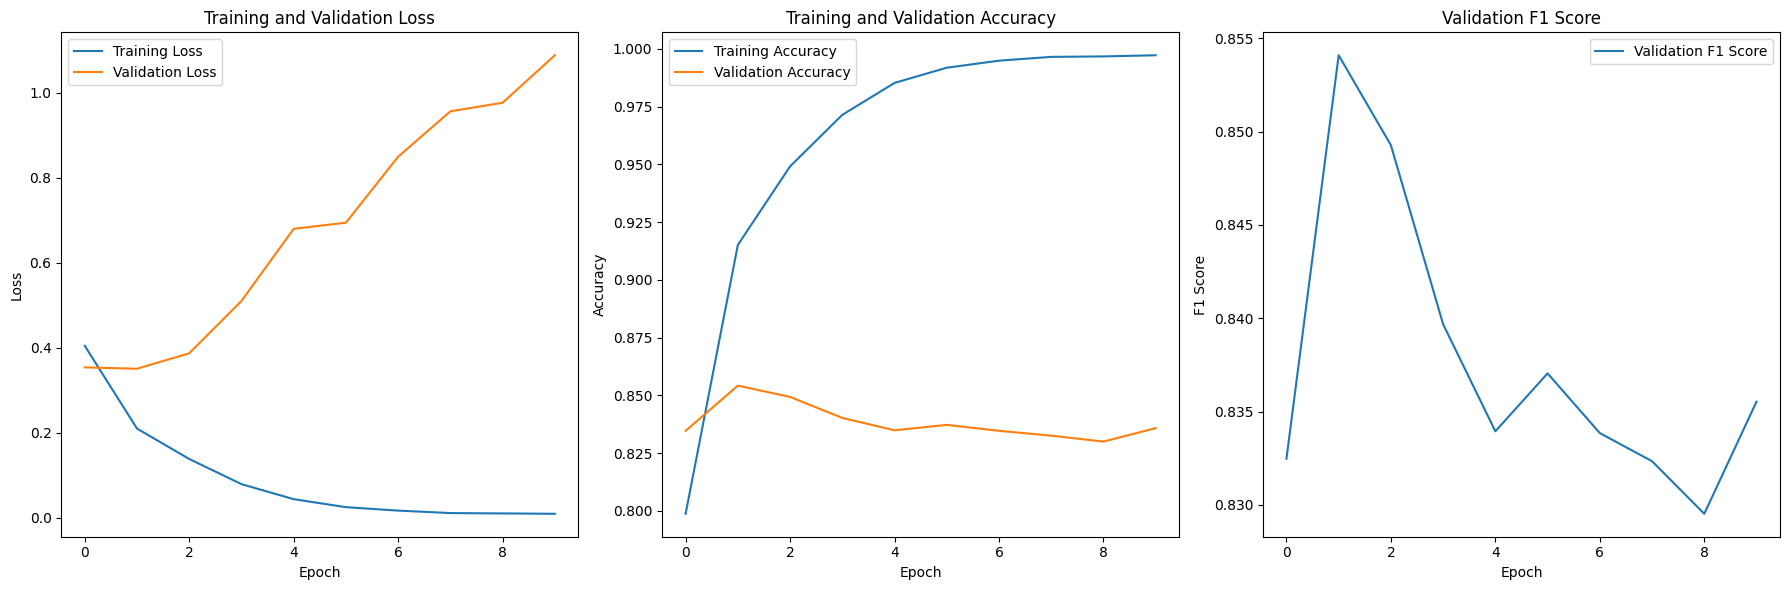

In [25]:
# train the model
model_instance.train_model(X_train, y_train, X_val, y_val, num_epochs=10)

#### Comments on Base Model

- Model seems to be overfitting the training set and not able to generalize well to unseen data
- High F1 score on validation set indicates that the model is able to strike a good balance between precision and recall
- This may indicate the following:

    model might be too complex relative to the complexity of the problem or,
    not enough data for the model to learn generalized patterns or,

## Hyperparameter Tuning

### Number of Epochs, Dropout and Batch size

In [30]:
# we tried the following modifications:
# adding dropout after the LSTM layer... tried 0.5 and 0.2 dropout rates
# increased batch size (tried 64, 512, 1024) to improve the model's ability to generalize... note that the default batch_size is 32
# changing the number of epochs to stop the model from overfitting

class SarcasmLSTM():
    def __init__(self, tokenized_data, vocab_size=10000, max_length=100):
        self.padded = tokenized_data
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.model = None  # initialize model attribute

    def build_model(self, embedding_dim=16):
        # Model definition
        self.model = Sequential([
                                  # Create a word embedding layer
                                  Embedding(self.vocab_size, embedding_dim, input_length = self.max_length),

                                  # Create an LSTM layer with output size 64
                                  Bidirectional(LSTM(64)),

                                  # Adding Dropout layer after LSTM
                                  #Dropout(0.2),

                                  # Fully connected output from the LSTM
                                  Dense(24, activation='relu'),

                                  # Use sigmoid activation for binary classification
                                  Dense(1, activation='sigmoid')
                                ])

        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, X_train, y_train, X_val, y_val, num_epochs=10):
          if self.model is None:
              print("Model has not been built. Call 'build_model' before training.")
              return

          # Define and initialize the F1 score callback
          f1_callback = F1ScoreCallback(self.model, X_val, y_val)

          print('\nTraining for', num_epochs, 'epochs.\n')
          # Training the model with the F1ScoreCallback
          history = self.model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[f1_callback], batch_size=1024)

          # Plotting training and validation loss
          plt.figure(figsize=(18, 6))

          plt.subplot(1, 3, 1)
          plt.plot(history.history['loss'], label='Training Loss')
          plt.plot(history.history['val_loss'], label='Validation Loss')
          plt.title('Training and Validation Loss')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()

          # Plotting training and validation accuracy
          plt.subplot(1, 3, 2)
          plt.plot(history.history['accuracy'], label='Training Accuracy')
          plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
          plt.title('Training and Validation Accuracy')
          plt.xlabel('Epoch')
          plt.ylabel('Accuracy')
          plt.legend()

          # Plotting F1 Score
          plt.subplot(1, 3, 3)
          plt.plot(f1_callback.f1_scores, label='Validation F1 Score')
          plt.title('Validation F1 Score')
          plt.xlabel('Epoch')
          plt.ylabel('F1 Score')
          plt.legend()

          plt.tight_layout()
          plt.show()

In [27]:
import gc

# If an instance of the model already exists, delete it
# to avoid building on previous model states
if 'model_instance' in locals():
    del model_instance

# Force garbage collection
gc.collect()

# Initialize the SarcasmLSTM class
model_instance = SarcasmLSTM(tokenized_data, vocab_size=10000, max_length=100)

# Build the model
model_instance.build_model(embedding_dim=16)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               41472     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 24)                3096      
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 204593 (799.19 KB)
Trainable params: 204593 (799.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Training for 6 epochs.

Epoch 1/6
20/20 [==============================] - 12s 442ms/step - loss: 0.6908 - accuracy: 0.5256 - val_loss: 0.6863 - val_accuracy: 0.5211
Epoch 2/6
20/20 [==============================] - 7s 380ms/step - loss: 0.6649 - accuracy: 0.6221 - val_loss: 0.6258 - val_accuracy: 0.7289
Epoch 3/6
20/20 [==============================] - 5s 279ms/step - loss: 0.5885 - accuracy: 0.7591 - val_loss: 0.5221 - val_accuracy: 0.8160
Epoch 4/6
20/20 [==============================] - 5s 248ms/step - loss: 0.4375 - accuracy: 0.8753 - val_loss: 0.4071 - val_accuracy: 0.8353
Epoch 5/6
20/20 [==============================] - 4s 207ms/step - loss: 0.2936 - accuracy: 0.8965 - val_loss: 0.3559 - val_accuracy: 0.8428
Epoch 6/6
20/20 [==============================] - 5s 241ms/step - loss: 0.2211 - accuracy: 0.9153 - val_loss: 0.3499 - val_accuracy: 0.8442


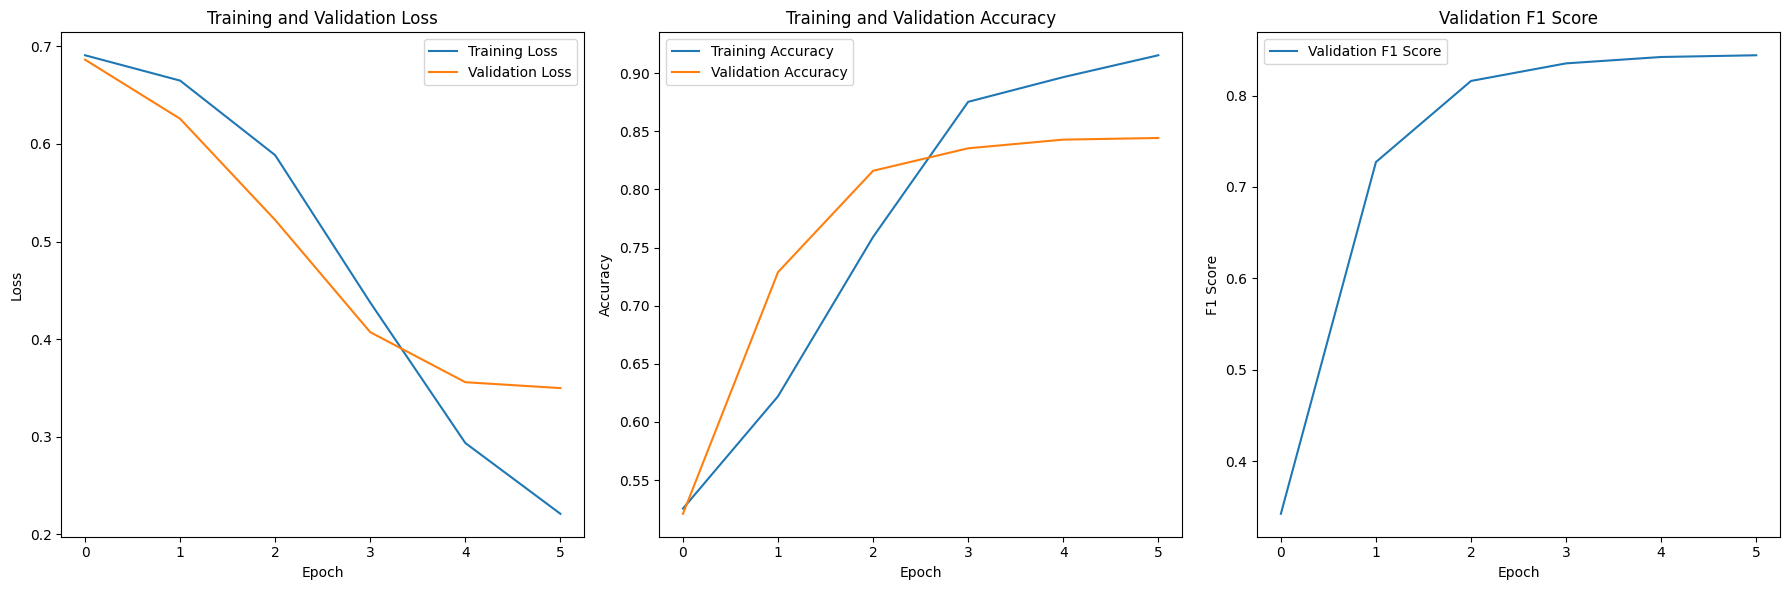

In [28]:
# train the model
model_instance.train_model(X_train, y_train, X_val, y_val, num_epochs=6)

#### Comments on Hyperparameter Tuning
- The model stops learning after ~6 epochs
- Increasing batch size to 1024 helps; the model is now able to generalize to the validation set better
- Validation F1 score now steadily increases as the model learns
- Dropping out neurons in the LSTM layer does not improve model performance... (commented out in the above code)

## Evaluation on Test Set

In [40]:
def evaluate_model(model, X_test, y_test):
        # Predictions
        y_pred_prob = model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int)  # Converting probabilities to binary output

        # Calculate Accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate F1 Score
        f1 = f1_score(y_test, y_pred, average='macro')  # Use 'binary' if it's a binary classification

        print(f'Test Accuracy: {accuracy:.4f}')
        print(f'Test F1 Score: {f1:.4f}')

In [41]:
evaluate_model(model_instance.model, X_test, y_test)

135/135 [==============================] - 1s 7ms/step
Test Accuracy: 0.8549
Test F1 Score: 0.8548


### Comments on Test Results

- Overall, the model demonstrates strong and balanced performance on both seen (validation) and unseen (test) data, indicating successful training and generalization.

- The similarity between the accuracy and F1 scores suggests that the dataset might be relatively balanced or that the model handles any class imbalance well.

- While the performance is strong, there's room for improvement. Further tuning, more complex models, or additional data could potentially improve performance.